# Assignment 3

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt
from keras_tuner import HyperParameters

2024-09-22 22:58:34.341929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

---
### Step 1: Data ingestion

You'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

In [2]:
# Provide the names for the feature columns since the CSV file with the data 
# does not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data from a CSV file into a pandas dataframe. Remember that each row
# is an example and each column in a feature.
car_data_init = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

# Display top five rows
print('Shape of data:', car_data_init.shape)
car_data_init.head()

Shape of data: (205, 26)


,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


---
### Step 2: Data preprocessing

This step is essential for preparing the data in a format that is suitable for ML algorithms. It helps ensure data quality and improvements in model performance.

### <span style="color:chocolate">Exercise 1:</span> Column selection (5 points)

To keep things simple, you will:

1. Retain only the following columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. Name the new dataframe *car_data*.
2. Display the data type of each column;
3. Convert the data type of each columns to numeric. Coerce missing values to NaN. Hint: use <span style="color:chocolate">pd.to_numeric()</span> method;
4. Display the data type of each column after the transformation performed at point 3.


In [3]:
# YOUR CODE HERE
# Make new dataframe from car_data_init for columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
car_data = car_data_init[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]

# Display data types of each column
print(f'\nOriginal data types:\n{car_data.dtypes}')

# Convert each column datatype to numeric
# Coerce missing values to NaN
car_data = car_data.apply(pd.to_numeric, errors = 'coerce')

# Display data types of dataframe
print(f'\nConverted data types:\n{car_data.dtypes}')


Original data types:
horsepower     object
peak-rpm       object
city-mpg        int64
highway-mpg     int64
price          object
dtype: object

Converted data types:
horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object


### <span style="color:chocolate">Exercise 2:</span> Example (row) selection (5 points)

To keep things simple again, you will:

1. Print the shape of the car_data;

2. Remove examples (rows) that have missing value(s). Note that in doing so, you will overwrite the car_data dataset. You should end up with 199 examples after this cleaning.

3. Print the shape of the car_data again.

It's important to acknowledge that there are multiple approaches to handling missing features, and simply discarding examples with any missing feature, though straightforward, may not be the most optimal solution. However, for the sake of simplicity, you will implement this strategy in this assignment.

In [4]:
# YOUR CODE HERE

# Print the shape of the data frame
print(car_data.shape)

# Remove missing values
car_data = car_data.dropna()

# Print the shape of the cleaned data frame
print(car_data.shape)

(205, 5)
(199, 5)


### <span style="color:chocolate">Exercise 3:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

Using NumPy and Pandas methods:

1. Create a list of indices corresponding to the rows in the car_data dataset. Call this list *indices*. Print this list;

2. Shuffle *indices* using the <span style="color:chocolate">np.random.permutation()</span> method. Call the resulting array *shuffled_indices*. Print this array;
    
3. Use the method <span style="color:chocolate">dataframe.reindex()</span> to change the ordering of the car_data dataset based on the order in the *shuffled_indices* array. Note that in doing so, you will overwrite the original dataset. Print the top 5 rows.

In [5]:
np.random.seed(0)
# YOUR CODE HERE
# Create list of indices corresponding to the rows in car_data dataset
indices = car_data.index.tolist()
print("Original Indices:")
print(indices)

# print(car_data.iloc[1,:])

# Shuffle indices
shuffled_indices = np.random.permutation(indices)
print("\nShuffled Indices:")
print(shuffled_indices)

# Change the ordering of the car_data dataset based on shuffles_indices
car_data = car_data.reindex(index=shuffled_indices)
car_data.head(5)

Original Indices:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204]

Shuffled Indices:
[ 19 175 109  95 182 189   5 145  13 166  64 127 170 151  83   7  34 135


,horsepower,peak-rpm,city-mpg,highway-mpg,price
19,70.0,5400.0,38,43,6295.0
175,92.0,4200.0,27,32,9988.0
109,97.0,5000.0,19,24,12440.0
95,69.0,5200.0,31,37,7799.0
182,52.0,4800.0,37,46,7775.0


### <span style="color:chocolate">Exercise 4:</span> Define outcome and features (5 points)

Create two dataframes as follows:

1. The first dataframe contains our outcome of interest: ['price']. Note, this is what we are aiming to predict. Name this dataframe Y. Print shape of Y.
2. The second dataframe contains our features of interest: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']. Name this dataframe X. Print shape of X.


In [6]:
# YOUR CODE HERE
# Create dataframe with outcome variable
Y = car_data[['price']]

# Print the shape of dataframe Y
print(Y.shape)

# Create dataframe with features from car_data
X = car_data.drop(columns = ['price'])

# Print the shape of dataframe X
print(X.shape)

(199, 1)
(199, 4)


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Partition the (X, Y) data into training, validation, and test sets using a splitting rule of [60%, 20%, 20%], with a random state set to 1234. Name the resulting dataframes as follows: X_train, X_val, X_test, Y_train, Y_val, Y_test. Hint: To create these three partitions you will utilize the train_test_split() method twice (all the other arguments of the method are set to default values.). You should obtain [119, 40, 40] examples for training, validation, and test, respectively.
2. Print the shape of each dataframe.

Note: The validation set is crucial for evaluating different hyperparameter configurations and selecting those that yield optimal model performance. This approach avoids utilizing the test dataset during model training, as it is assumed to be "unknown" at that stage.

In [7]:
# YOUR CODE HERE
# Split data into 60% training
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size= 0.4 , random_state= 1234)

# Further split the test data into equal parts validation and test
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size= 0.5 , random_state= 1234)

# Printing the shape of each array
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_val shape: {Y_val.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (119, 4)
X_val shape: (40, 4)
X_test shape: (40, 4)
Y_train shape: (119, 1)
Y_val shape: (40, 1)
Y_test shape: (40, 1)


### <span style="color:chocolate">Exercise 6:</span> Data standardization (10 points)

With this concept in mind, complete the following tasks:

1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset. Are these values uniformly scaled across features?

2. Standardize all features in X_train, X_val, and X_test. Label the resulting dataframes as X_train_std, X_val_std, and X_test_std, respectively. Hint: standardize the validation and test data using the mean and standard deviation computed from the training data. Why?

3. Similar to point 2. but now standardize the outcome variable. Label the resulting dataframes as Y_train_std, Y_val_std, and Y_test_std.

In [8]:
# YOUR CODE HERE
# Calculate quantile values for 0.25, 0.5, 0.75, and 0.95
quantiles = X_train.quantile([0.25, 0.5, 0.75, 0.95])

# Print the quantile values
print(quantiles)
print("\nQuantiles for each feature are roughly in the same range.", 
      "\nThis indicates the features are uniformly scaled.")

# Standardize all features in X_train, X_val, X_test
X_mean = X_train.mean()
X_std = X_train.std()
X_train_std = (X_train - X_mean) / X_std
X_val_std = (X_val - X_mean) / X_std
X_test_std = (X_test - X_mean) / X_std

print("\nWe use the training data to standardize the data since it should mimic", 
      "\nthe data encountering new data as a means of preventing overfitting of the data.",
      "\nThe data must generalize.")


# Standardize all features in X_train, X_val, X_test
Y_mean = Y_train.mean()
Y_std = Y_train.std()
Y_train_std = (Y_train - Y_mean) / Y_std
Y_val_std = (Y_val - Y_mean) / Y_std
Y_test_std = (Y_test - Y_mean) / Y_std

      horsepower  peak-rpm  city-mpg  highway-mpg
0.25        69.0    4800.0      19.0         25.0
0.50        92.0    5000.0      25.0         31.0
0.75       116.0    5500.0      31.0         37.0
0.95       182.2    5900.0      37.0         42.1

Quantiles for each feature are roughly in the same range. 
This indicates the features are uniformly scaled.

We use the training data to standardize the data since it should mimic 
the data encountering new data as a means of preventing overfitting of the data. 
The data must generalize.


---
### Step 3: Exploratory data analysis (EDA)

EDA plays a very important role in ML. The goal here is to develop a good understanding of our training dataset, identify any data quality issues, understand patterns and relationships, which in turn, aids in subsequent modeling and interpretations.

### <span style="color:chocolate">Exercise 7:</span> Scatterplot matrix (10 points)

In this exercise you will use some simple yet useful techniques to visualize the distribution of the data. 

Let's start with:

1. A scatterplot matrix to visualize the pair-wise correlations between different features and outcome in the (X_train_std, Y_train_std) data. You will use the <span style="color:chocolate">sns.pairplot()</span> method from the seaborn library imported at the top of the notebook;
2. Is any of the variables in the data normally distributed? Is it necessary for the explanatory or target variable to be normally distributed in order to train a ML model?

/home/jdhesi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jdhesi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jdhesi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jdhesi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

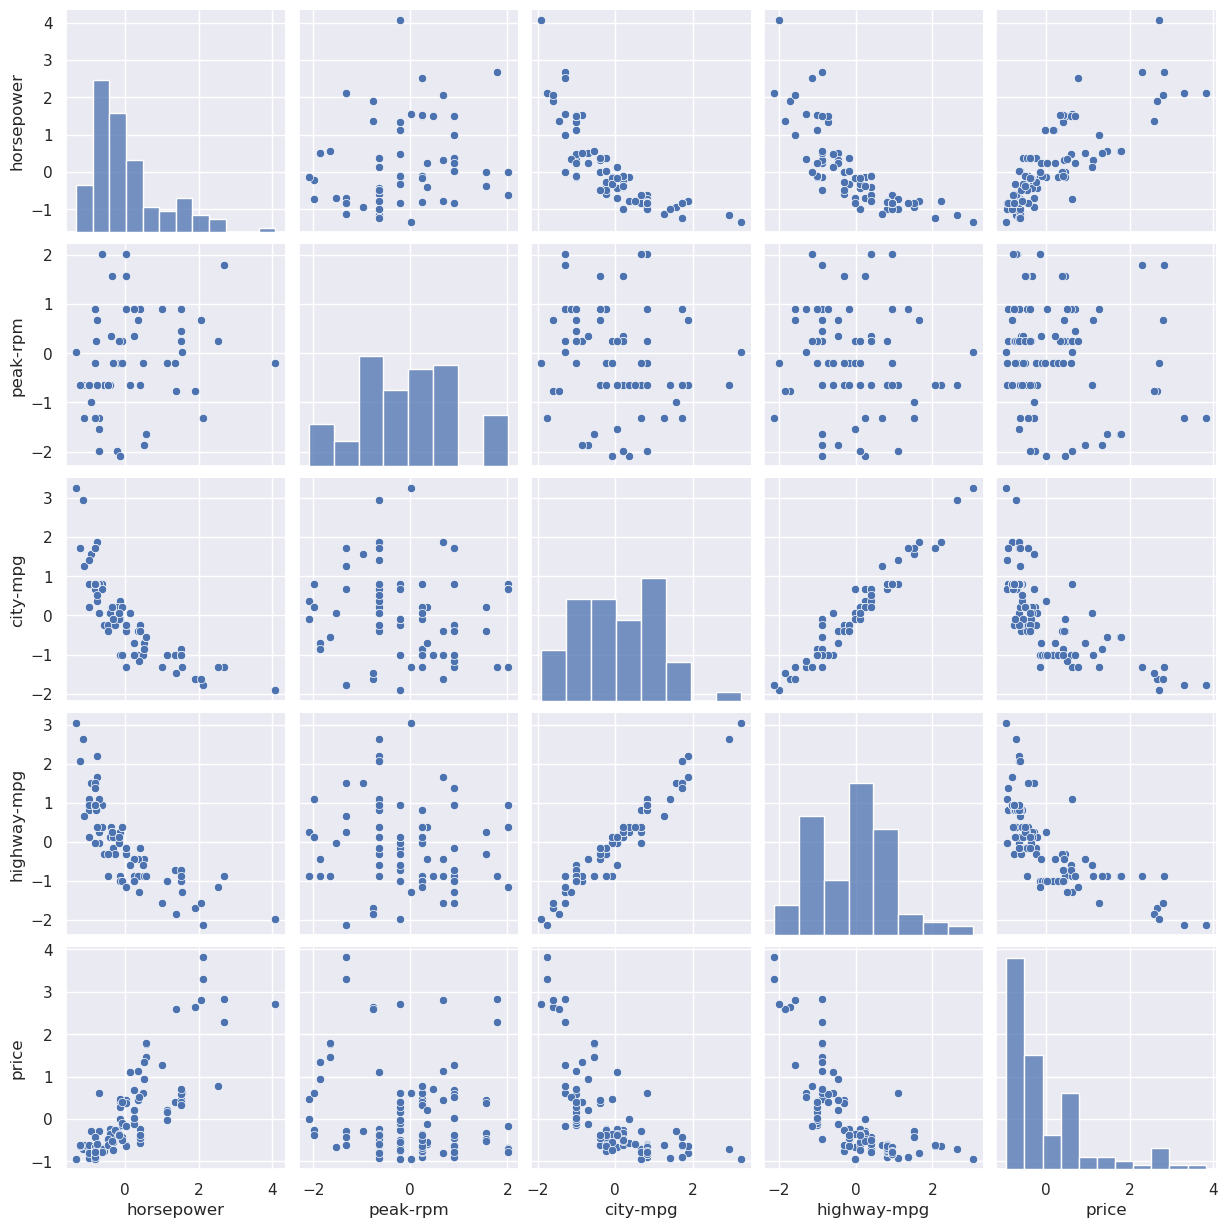

In [9]:
# YOUR CODE HERE
# Combine the training dataframes
training_df = pd.concat([X_train_std, Y_train_std], axis=1)

# Create pairplot
sns.pairplot(training_df)

The peak-rpm, city-mpg, and highway-mpg variables appears to be normally distributed.
It is not necessary for the the variables to be normally for most machine learning model as they don't assume normality in the data.

### <span style="color:chocolate">Exercise 8:</span> Correlation matrix (10 points)

In this exercise you will:

1. Plot a correlation matrix in the form of a heatmap to visualize the linear relationships between different features and outcome in the (X_train_std, Y_train_std) data. Hint: this example here is very useful: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
2. Answer the following questions: 
 - Which two features are likely to be most redundant?
 - Which feature is likely to be least useful for predicting price?

<Axes: >

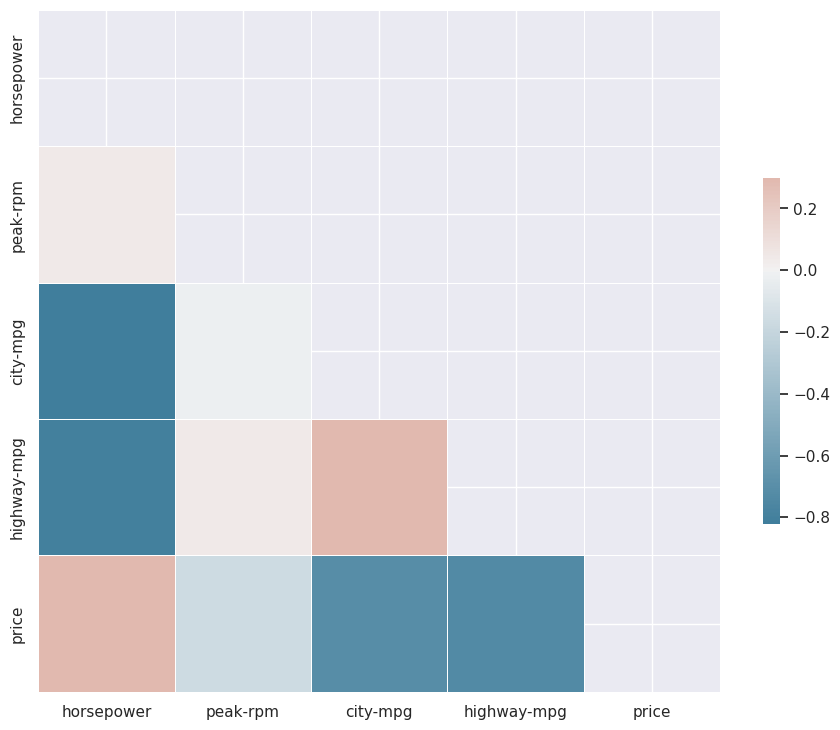

In [10]:
# YOUR CODE HERE
# Compute the correlation matrix
corr = training_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

1. City-mpg and highway-mpg are most likely to be redundant as they have similar correlation values to the other variables.
2.  peak-rpm seems to be the least useful for predicting price due to its low absolute correlation value.

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 9:</span> Baseline model (5 points)

Let's start by evaluating a baseline model. Precisely, you'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input.

1. Implement this baseline using the Y_train_std data and print the average price. Note: You can revert the price variable to the original scale for interpretation purposes.

In [11]:
# YOUR CODE HERE
# Average price
std_baseline_price = Y_train_std.mean()

# Baseline in original scale (before standardization):
baseline_price = (std_baseline_price * Y_std) + Y_mean

# Print the baseline price
print(baseline_price)

price    13139.92437
dtype: float64


### <span style="color:chocolate">Exercise 10:</span> Improvement over Baseline with TensorFlow (10 points)

Let's train a linear regression model much like we did in the previous assignment, but this time using TensorFlow. 

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: refer to Demo 3 in [bCourses/Modules/Live Session Demos](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) for an example.
2. Build and compile a model using the build_model() function and the (X_train_std, Y_train_std) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_std, Y_train_std) data. Set num_epochs = 5. Pass the (X_val_std, Y_val_std) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
4. Generate a plot with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

More notes on point 1: the idea is to build a *computational graph* for linear regression, and then send data through it. There are many ways to build graphs, but [TenforFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. 

In [12]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim; single input for linear regression
      input_shape=(num_features, ),  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the MSE loss and the optimizer above
  model.compile(loss='mse', optimizer=optimizer)
    
  return model

/home/jdhesi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-22 22:58:45.813662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 22:58:45.832143: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5319 - val_loss: 5.0676
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2480 - val_loss: 4.8811
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9793 - val_loss: 4.7041
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7250 - val_loss: 4.5360
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4842 - val_loss: 4.3765


/tmp/ipykernel_227146/775339235.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"


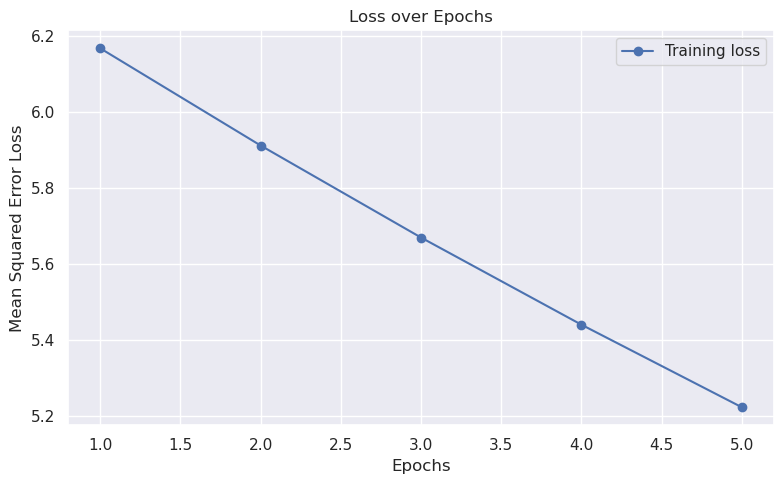

In [13]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE
LR = 0.0001
model_tf = build_model(X_train.shape[1], learning_rate=LR)

# 3. Fit the model
# YOUR CODE HERE
# Do a single gradient update.
epoch_count = 5

model_tf = model_tf.fit(
  x = X_train_std,
  y = Y_train_std,
  epochs = epoch_count,
  batch_size=2,
  validation_data = (X_val_std, Y_val_std),
  verbose=1
  )

history_dict = model_tf.history
history_dict.keys()

# Get the model Loss
loss = history_dict['loss']

# Create a range of epoch numbers to match the length of the loss list
epochs = range(1, len(loss) + 1)  # Create a list of epochs starting from 1 to the number of epochs

# Plot the losses vs epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.tight_layout()
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 11:</span> Hyperparameter tuning (10 points)

1. Fine-tune the **learning rate** and **number of epochs** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). If you decide to work with the Keras Tuner, define a new model building function named <span style="color:chocolate">build_model_tuner()</span>.

After identifying your preferred model configuration, print the following information:

2. The learned parameters of the tuned model (this should include the bias term). Hint: use  <span style="color:chocolate">[model_name].layers[0].get_weights()</span>.
3. The loss at the final epoch on both the training and validation datasets;
4. The difference between the last-epoch loss observed on the training and validation datasets.


Please note that we will consider 'optimal model configuration' any last-epoch training loss that is below 0.31 and any last epoch validation loss that is below 0.48.

Epoch 1/10
 1/60 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 4.1297

/home/jdhesi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1697 - val_loss: 1.1192
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8697 - val_loss: 0.5037
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4450 - val_loss: 0.3648
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3390 - val_loss: 0.3286
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3012 - val_loss: 0.3152
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2826 - val_loss: 0.3079
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2712 - val_loss: 0.3031
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2635 - val_loss: 0.2998
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2580 - val_loss: 0.2976
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2540 - val_loss: 0.2962
[2.8608713150024414, 0.8008638620376587, 0.4642811119556427, 0.3715713322162628, 0.3370455801486969, 0.3198450207710266, 0.3093734681606293, 0.3023538589477539, 0.2974622

/tmp/ipykernel_227146/4165790651.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"


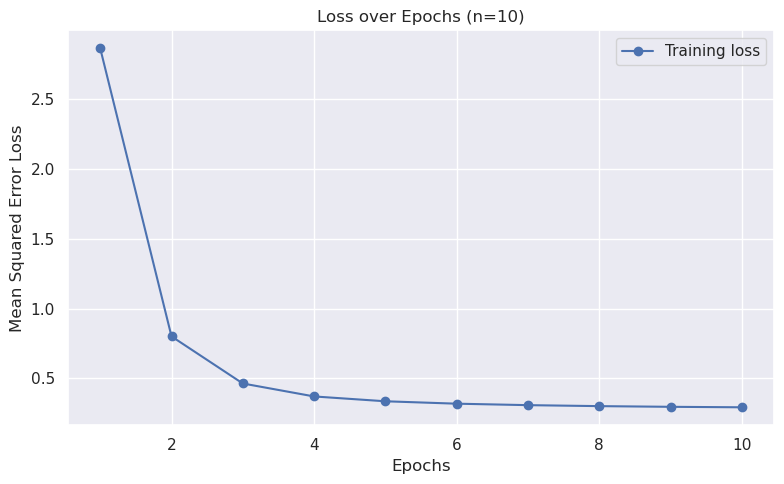

***************
Learned Parameters of the tuned model:
Weights (Kernel): 
[[ 0.90529764]
 [-0.1776107 ]
 [ 0.1331063 ]
 [-0.12926644]]
Bias (Intercept): 
[0.0067233]

Last Epoch Values (rounded to 4 decimals): 
Epoch: 10; Loss = 0.294; val_loss = 0.2962 

Difference between last validation and training loss (rounded to 4 decimals): 0.0022


In [22]:
tf.random.set_seed(0)
# YOUR CODE HERE

# Build and compile model
LR = 0.0057
model_tuned= build_model(X_train.shape[1], learning_rate=LR)

# Do a single gradient update.
epoch_count = 10

model_tf_tuned = model_tuned.fit(
  x = X_train_std,
  y = Y_train_std,
  epochs = epoch_count,
  batch_size=2,
  validation_data = (X_val_std, Y_val_std),
  verbose=1
  )

history_dict_tuned = model_tf_tuned.history
history_dict_tuned.keys()

# Get the model Loss
loss = history_dict_tuned['loss']

# Create a range of epoch numbers to match the length of the loss list
epochs = range(1, len(loss) + 1)  # Create a list of epochs starting from 1 to the number of epochs

# Plot the losses vs epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"
plt.title(f'Loss over Epochs (n={max(epochs)})')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.tight_layout()
plt.legend()
plt.show()

# 2. Print the hypertuning parameters
weights, bias = model_tuned.layers[0].get_weights()
print("***************")
print("Learned Parameters of the tuned model:")
print(f"Weights (Kernel): \n{weights}")
print(f"Bias (Intercept): \n{bias}")

# 3. Print loss and val_loss for last epoch
train_loss_final = round(loss[-1],4)
val_loss_final = round(history_dict_tuned['val_loss'][-1],4)
print(f"\nLast Epoch Values (rounded to 4 decimals):",
      f"\nEpoch: {max(epochs)}; Loss = {train_loss_final}; val_loss = {val_loss_final} ")

# 4. Calculate and print the difference between the last-epoch training and validation loss
loss_difference = round((val_loss_final - train_loss_final), 4)
print(f"\nDifference between last validation and training loss (rounded to 4 decimals): {loss_difference}")

---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized (tuned) model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 12:</span> Computing MSE (10 points)

1. Calculate the MSE on both (X_train_std, Y_train_std) and (X_test_std, Y_test_std) datasets. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your observations.

4. Generate a plot to visualize the accuracy of the predictions. Plot the actual (observed) Y_test values on the x-axis and the predicted Y_test values on the y-axis. Additionally, include a 45-degree line in the plot for reference. Ensure that the plot contains appropriate axis labels and a title. Provide commentary on the model's fit based on this visualization. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras. 

In [15]:
# YOUR CODE HERE
# 1a. Evaluate MSE on the training dataset
train_mse = round(model_tuned.evaluate(X_train_std, Y_train_std, verbose=0),4)
print(f"Training MSE: {train_mse}")

# 1b. Evaluate MSE on the test dataset
test_mse = round(model_tuned.evaluate(X_test_std, Y_test_std, verbose=0), 4)
print(f"Test MSE: {test_mse}")


Training MSE: 0.2859
Test MSE: 0.3086


* Since the MSE on the training set and test set are similar, only about **0.02** off, and low, no greater than **0.31**, the model generalizes well. 
* There are no obvious signs of overfitting or underfitting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


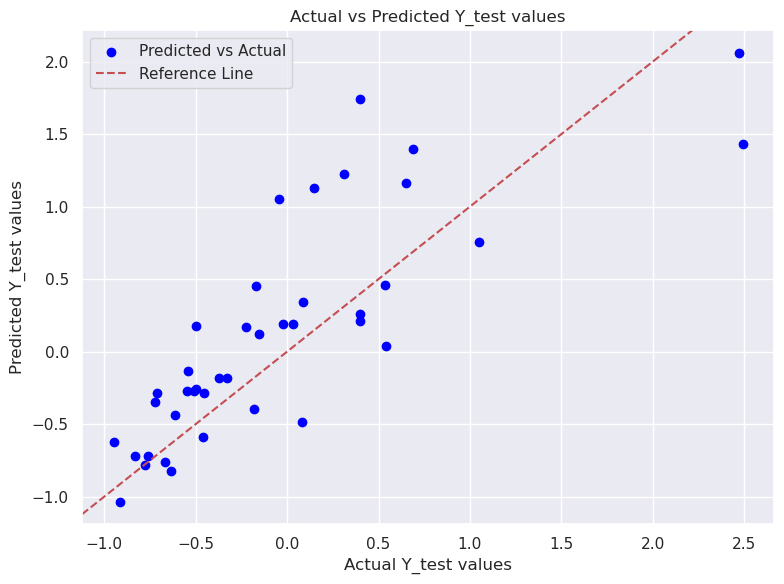

In [16]:
# 3. Get predictions for the test data
Y_test_pred = model_tuned.predict(X_test_std)

# Generate a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_std, Y_test_pred, color='blue', label='Predicted vs Actual')

# Plot a 45-degree reference line# Add a 45-degree reference line
plt.axline((0, 0), slope=1, color='r', linestyle='--', label = 'Reference Line')

# Add labels and title
plt.xlabel('Actual Y_test values')
plt.ylabel('Predicted Y_test values')
plt.title('Actual vs Predicted Y_test values')
plt.legend()
plt.tight_layout()
plt.grid = True

# Show the plot
plt.show()

Based off this visualization:
* There are no significant skews away from the reference line.
* The hyperatuned model appears to predict the Y_test_std data well. 

Therefore, it can be surmised that the model generalizes well.

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

In Exercise 12, you reported an aggregated MSE. Let's revisit the exercise by:

1. Performing a subgroup evaluation of the model. Specifically, calculate the test data MSE for the following makes: ['alfa-romero', 'audi', 'chevrolet', 'dodge', 'honda'].
2. Addressing the question: Is the model "fair" across each make?

In [17]:
# YOUR CODE HERE